So without going into too much detail, my task at hand is to determine whether or not a new version of a website is converting more people based on localized translations. Conversion rates of users were supplied and below we take a look at how some of the variables result in more conversion than others 

In [1]:
import pandas as pd,warnings,numpy as np,matplotlib.pyplot as plt
from scipy import stats
from sklearn.tree import DecisionTreeClassifier as rfc
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
%matplotlib inline

In [42]:
test_table, user_table = pd.read_csv("test_table.csv",header=0), pd.read_csv("user_table.csv",header=0)
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [43]:
test_table.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [44]:
total_df = pd.merge(test_table,user_table,on="user_id")
total_df.sort_values(['date'])
test_sample = total_df[total_df.test==1]
control_sample = total_df[total_df.test==0]

We needed to merge cells so we could have country and conversion in the same table.

In [21]:
t,pv = stats.ttest_ind(control_sample.conversion,test_sample.conversion,equal_var=False)
print "The average of the control sample is: ",control_sample[control_sample.country!='Spain'].conversion.mean()
print "The average of the test sample is: ",test_sample.conversion.mean()
print "The t-stat is ",t
print "The p-val is ",pv

The average of the control sample is:  0.0482917905575
The average of the test sample is:  0.0434111616784
The t-stat is  18.2913931877
The p-val is  1.03120990613e-74


We reject the null hypothesis of equal averages and there appears to be a 10% drop. That's drastic.

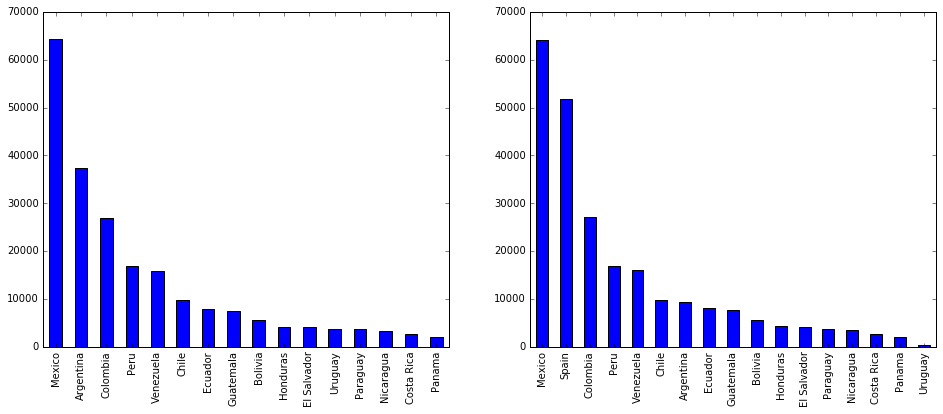

In [45]:
fig,axs = plt.subplots(1,2)
test_sample.country.value_counts('user_id').apply(lambda x: x*len(test_sample.country)).plot(kind='bar',ax=axs[0],figsize=(16,6))
control_sample.country.value_counts('user_id').apply(lambda x: x*len(control_sample.country)).plot(kind='bar',ax=axs[1],figsize=(16,6))

After doing a little digging, something interesting happened...Based on the charts above, it looks like Uruguary is better represented in the Test Sample and poorly represented in the Control Sample while Argentina is poorly represented in the Control Sample and well represented in the Test Sample!

In [39]:
old = control_sample[control_sample.country!='Spain'].groupby('country').mean().conversion.as_matrix()
new = test_sample.groupby('country').mean().conversion.as_matrix()
F,p = stats.f_oneway(old,new)
print "The F stat is: ",F
print "The p-value is: ",p

The F stat is:  0.00183930310254
The p-value is:  0.966075714396


Now this is a completely different story. If we adjust for country, we get that they're from the same distribution!

In [46]:
print sum(old-new)

0.0030812045936


So on average, the control sample actually does better by a modest margin.

In [53]:
def check_country_function(control_df,test_df,threshold):
    df1 = control_df.country.value_counts('user_id')
    df2 = test_df.country.value_counts('user_id')
    for country_ in list(pd.unique(test_df.country)):
        percent_1 = df1[country_]/float(df1[country_]+df2[country_])
        percent_2 = df2[country_]/float(df1[country_]+df2[country_])
        if percent_1 < threshold or percent_2 < threshold:
            return False
    return True

The final question was to design a function that determines whether or not this same problem happened again. I checked for a disproportion in samples with respect to country. You could easily broaden this to different variables also. I added a threshold value which the function checks to see if the percentage of total oberservations on either side is below a threshold. If it is, then this function will return False since the same problem is happening given how lenient we are with respect to delegating more samples to one side or another.

In [54]:
check_country_function(control_sample,test_sample,0.40)

False

Finally, the function is test on the control sample and test sample with a threshold of 0.40 and it works!